In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'
dir_figure = './outputs/figures'
dir_target = './outputs/img_to_be_labeled'

seed = 0
method = 'betti-curve'
n_bins = 100
thresholds = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

input_shape = (28, 28, 1) 
n_classes = 7
n_random_samples = 100

In [2]:
import sys

sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import json
import labelme
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

In [3]:
seed_all(seed)

In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape))
y = df['label'].values

X = X.astype(np.float32)
X /= 255.0

y = y.astype(np.int64)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
def iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = np.logical_or(mask1, mask2).sum()
    return intersection / union

In [6]:
cnn = tf.keras.models.load_model(os.path.join(dir_ckpt, 'hmnist_cnn_seed0'))
cnn_tda = tf.keras.models.load_model(os.path.join(dir_ckpt, 'hmnist_cnn_tda_seed0'))

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_8', global_layer_name='conv1d_8')


results = {'cnn': [], 'cnn_tda': []}
fpath_list = glob(os.path.join(dir_target, '*.npy'))
for fpath in fpath_list:
    name = fpath.split('/')[-1]
    name = name.split('.')[0]
    idx, label = name.split('_')
    idx, label = map(int, [idx, label])
    
    img  = X[idx:idx+1]
    tda  = X_tda[idx:idx+1]
    mask = np.load(fpath)
    mask = mask.astype(bool)
    
    gradcam_cnn_tda.to_heatmap([img, tda], true_label=label)
    gradcam_cnn.to_heatmap(img, true_label=label)
    
    heatmap_cnn = gradcam_cnn._cache['heatmap'][0][:, :, 0] / 255.0
    heatmap_cnn_tda = gradcam_cnn_tda._cache['heatmap'][0][:, :, 0] / 255.0
    
    scores_cnn = []
    scores_cnn_tda = []
    for threshold in thresholds:
        mask_cnn = (heatmap_cnn > threshold).astype(bool)
        mask_cnn_tda = (heatmap_cnn_tda > threshold).astype(bool)
        
        scores_cnn.append(iou(mask, mask_cnn))
        scores_cnn_tda.append(iou(mask, mask_cnn_tda))

    results['cnn'].append(scores_cnn)
    results['cnn_tda'].append(scores_cnn_tda)
    
print('CNN localization: ', np.mean(results['cnn'], axis=0))
print('CNN-TDA Net localization: ', np.mean(results['cnn_tda'], axis=0))

2022-10-31 17:31:44.027335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


CNN localization:  [0.1742199  0.16251733 0.14631223 0.12961974 0.10755435 0.08640565]
CNN-TDA Net localization:  [0.22256591 0.25218365 0.29454103 0.29155978 0.26125743 0.22047614]


Visualize the localization test.

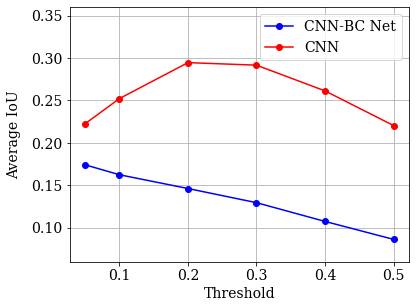

In [7]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.figure(figsize=(6, 4.5))
plt.plot(thresholds, np.mean(results['cnn'], axis=0), 'bo-', label='CNN-BC Net')
plt.plot(thresholds, np.mean(results['cnn_tda'], axis=0), 'ro-', label='CNN')
plt.grid()
plt.legend(loc=1)
plt.ylim(0.06, 0.36)
plt.xlabel('Threshold')
plt.ylabel('Average IoU', labelpad=10)
plt.tight_layout()
plt.savefig(os.path.join(dir_figure, 'iouplot.pdf'), dpi=200)
plt.show()

Visualize some samples

In [7]:
cnn = tf.keras.models.load_model(os.path.join(dir_ckpt, 'hmnist_cnn_seed0'))
cnn_tda = tf.keras.models.load_model(os.path.join(dir_ckpt, 'hmnist_cnn_tda_seed0'))

gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_8', global_layer_name='conv1d_8')

2022-11-09 17:49:15.624185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [11]:
fpath_list = ['352_2', '2102_6', '4919_4', '5720_4']

for fpath in fpath_list:
    idx, label = fpath.split('_')
    idx, label = map(int, [idx, label])

    img = X[idx:idx+1]
    tda  = X_tda[idx:idx+1]
    mask = np.load(os.path.join(dir_target, fpath + '.npy'))
    mask_ = np.ma.masked_where(mask == 0, mask)
        
    gradcam_cnn_tda.to_heatmap([img, tda], target_label=label, true_label=label)
    gradcam_cnn.to_heatmap(img, target_label=label, true_label=label)
    
    heatmap_cnn = gradcam_cnn._cache['heatmap'][0][:, :, 0] / 255.0
    heatmap_cnn_tda = gradcam_cnn_tda._cache['heatmap'][0][:, :, 0] / 255.0
    
    mask_cnn = (heatmap_cnn > 0.2).astype(bool)
    mask_cnn_tda = (heatmap_cnn_tda > 0.2).astype(bool)

    ### Image
    fig = plt.figure(figsize=(4, 4), frameon=False)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'{idx}_img.png'), dpi=100)
    
    plt.cla()
    plt.clf()
    plt.close()
    
    ### Mask
    fig = plt.figure(figsize=(4, 4), frameon=False)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(255.0 * mask, cmap='bone')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'{idx}_mask.png'), dpi=100)
    
    plt.cla()
    plt.clf()
    plt.close()
    
    ### Image with mask
    fig = plt.figure(figsize=(4, 4), frameon=False)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.imshow(mask_, alpha=0.4, cmap='jet')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'{idx}_img_mask.png'), dpi=100)
    
    plt.cla()
    plt.clf()
    plt.close()
    
    ### CNN Grad-CAM mask
    fig = plt.figure(figsize=(4, 4), frameon=False)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(255.0 * mask_cnn, cmap='bone')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'{idx}_cnn_mask.png'), dpi=100)
    
    plt.cla()
    plt.clf()
    plt.close()
    
    ### CNN-BC Net Grad-CAM mask
    fig = plt.figure(figsize=(4, 4), frameon=False)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(255.0 * mask_cnn_tda, cmap='bone')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'{idx}_cnn_tda_mask.png'), dpi=100)

    plt.cla()
    plt.clf()
    plt.close()